In [1]:
%load_ext autoreload

In [3]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

from csv_parser import CSVParser

In [4]:
# Define categories based on ranges or discrete values
parser= CSVParser()
total_df = parser.retrieve_training_data()

# total_df = pd.read_csv("../../resources/resampled_data_h.csv")

total_df['etaParsed'] = pd.to_datetime(total_df['etaParsed'])
total_df["time"] = pd.to_datetime(total_df['time'])

start_date = pd.to_datetime('2024-01-01')

total_df["etaParsed"] = (total_df['etaParsed'] - start_date).dt.days



time_diffs = total_df["time"].diff()
time_interval = time_diffs.dropna().iloc[0]
time_interval = int(time_interval.total_seconds()/(60*20))



total_df.set_index("time", inplace=True)


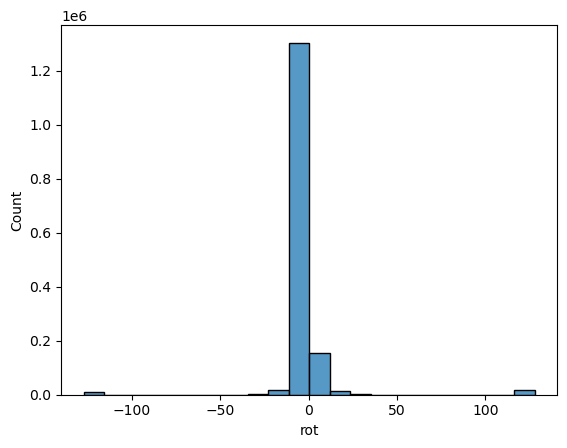

Empty DataFrame
Columns: [cog, sog, rot, heading, navstat, latitude, longitude, vesselId, portId, etaParsed, UN_LOCODE, ISO, portLongitude, portLatitude, rot_cat]
Index: []
Empty DataFrame
Columns: [cog, sog, rot, heading, navstat, latitude, longitude, vesselId, portId, etaParsed, UN_LOCODE, ISO, portLongitude, portLatitude, rot_cat]
Index: []


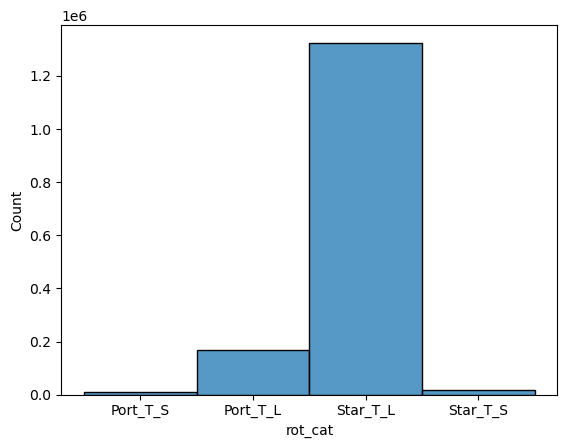

In [ ]:
#I want to make rot_values a categorical
toy_data = total_df.copy()
rot_values = total_df["rot"]

sns.histplot(x = "rot", data = total_df)

plt.show()

#This show me that I have ROT-values that are quite small, most are between 0 and -40 (by eyesight). I want to make this into a categorical based on what I see.
#But be careful about the y-axis I have a big amount of values other than between 0 and -40.

#Want to make this into a categorical.
#I want my bins to be [-127, -126, 0, 126, np.inf]

bins = [-127, -126, 0, 127, np.inf] #Based on the interpretation of the ROT and the histogram.

labels = ["Port_T_S", "Port_T_L", "Star_T_L", "Star_T_S"]

total_df["rot_cat"] = pd.cut(rot_values, bins = bins, labels = labels, right = False)

no_df = total_df[total_df["rot_cat"]=="No_T"]

print(no_df.head())

min_df = total_df[total_df["rot"]<=-128]

print(min_df)

#I have no values which are -128 or lower, so I change my bins.
sns.histplot(x = "rot_cat", data = total_df)
plt.show()

#Will check if this actually changes anything based on the test error.

total_df.drop()

Index(['cog', 'sog', 'rot', 'heading', 'latitude', 'longitude', 'vesselId',
       'portId', 'etaParsed', 'UN_LOCODE', 'ISO', 'portLongitude',
       'portLatitude', 'shippingLineId', 'CEU', 'DWT', 'GT', 'NT',
       'vesselType', 'breadth', 'depth', 'draft', 'enginePower', 'freshWater',
       'fuel', 'homePort', 'length', 'maxHeight', 'maxSpeed', 'maxWidth',
       'rampCapacity', 'yearBuilt', 'rot_cat'],
      dtype='object')
(1520450, 33)


<Axes: xlabel='draft', ylabel='Count'>

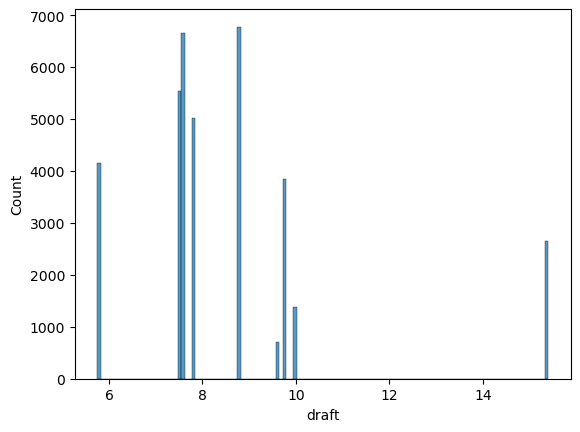

In [ ]:
print(total_df.columns)



dwt = total_df["DWT"] #Deadweight Tonnage. For Deep Sea vessels this is usually larger than 10 000.
length = total_df["length"] #Length. For deep sea vessels this is usually larger than 150m.
breadth = total_df["breadth"] #A type of width. For deep sea vessels this is usually between 25-60m.
draft = total_df["draft"] #Draft. For deep sea vessels this is usually between 10-20m.

#Plots

#print(dwt.head())

#sns.histplot(x = "length", data = total_df) Most lengths are larger than 150m.

#sns.histplot(x = "breadth", data = total_df)
#print(total_df.columns[total_df.columns.duplicated()])
#print(total_df.index[total_df.index.duplicated()])
print(total_df.shape)



#Change index into counts for now.
toy_data = total_df.copy()
toy_data.reset_index(drop=True, inplace=True)
#sns.histplot(x = "length", data = total_df) #Most lengths are larger than 150m.
#sns.histplot(x = "DWT", data = toy_data) #Most are between 10000-30000.
#sns.histplot(x = "breadth", data = toy_data) #Most are between 25-35m.3
#sns.histplot(x = "draft", data = toy_data) #Most have draft lower than 10m. 


In [6]:
print(total_df.columns)

Index(['cog', 'sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude',
       'vesselId', 'portId', 'etaParsed', 'UN_LOCODE', 'ISO', 'portLongitude',
       'portLatitude', 'rot_cat'],
      dtype='object')


In [16]:
#Looking at NAVSTAT
toy_data = total_df.copy()
toy_data.reset_index(drop=True, inplace=True)
#sns.histplot(x = "navstat", data = total_df)
#plt.show()

#print(total_df.shape)

#print(toy_data["navstat"].unique())
#A lot of 0, i.e under way using engine.
#Some 1, which means at anchor
#A lot of 5, which means moored
#print(toy_data["navstat"].value_counts())
#Which means that I want navstat to be a categorical, with 0, 1 and 5 and everything else. 

#print(toy_data.dtypes)

#Want to make this into a categorical.
#I want my bins to be [-127, -126, 0, 126, np.inf]

important_values = {0: "OMW_E", 1: "Anchor", 5: "Moored"}

# Create a new column with categories
toy_data['navstat_cat'] = toy_data['navstat'].apply(lambda x: important_values.get(x, "Other"))

print(toy_data[["navstat_cat","navstat"]].head(30))

   navstat_cat  navstat
0        OMW_E        0
1       Anchor        1
2        OMW_E        0
3       Anchor        1
4        OMW_E        0
5       Moored        5
6       Moored        5
7       Moored        5
8       Anchor        1
9       Moored        5
10      Anchor        1
11      Moored        5
12       OMW_E        0
13      Moored        5
14       OMW_E        0
15      Moored        5
16       OMW_E        0
17      Anchor        1
18       OMW_E        0
19      Moored        5
20      Moored        5
21       OMW_E        0
22       OMW_E        0
23      Moored        5
24      Moored        5
25      Moored        5
26      Moored        5
27      Anchor        1
28       OMW_E        0
29      Moored        5
